In [36]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests


import math


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [6]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_teste(series,title='',prints=False):    
    summay = ''
    if prints:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC',) 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():        
        out[f'critical value ({key})']=val
        
    if prints:
        display(pd.DataFrame(out))
    
    
    
    if result[1] <= 0.05:
        summary = "Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary"
        if prints:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")        
    else:
        summary = "Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary"
        if prints:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            
    
    return(result[1],title,result[0],result[2],result[3],result[4],result[5],summary) 

def TooDifferent(item1,item2):
    print(df[item1].sum(),'',df[item2].sum())
    return (df[item1].sum()/10 >  df[item2].sum() or  df[item2].sum()/10 >  df[item1].sum())

In [8]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [12]:
dfOutli = []
df = df_count_day_typeGRP.resample('QS').sum().copy()
df = df['2012-01-01':]
valor = df['total'].sum()# - 1619483 - 1366115 - 813246
for i in df.columns:    
    dfOutli.append({'nome':i,'Qtd':df[i].sum(),'Percent':round((df[i].sum()*100)/valor,2),'QtdDiasZero':df[df[i]==0][[i]].count().item(),'QtdNaoZero':df[df[i]!=0][[i]].count().item()})

    
#PEGAR SO AQUELES QUE TEM QUANTIDADE SENAO NAO ADIANTA FAZER VAR
    
dfValidTypes = pd.DataFrame(dfOutli).sort_values(by='Percent',ascending=False)
# ver apenas aqueles que tem dados em pelo menos 50% ou mais dos quartis
#display(dfValidTypes[dfValidTypes['QtdNaoZero']>12])

dfListOfTypes = np.array(dfValidTypes[dfValidTypes['QtdNaoZero']>12]['nome'])
dfListOfTypes = np.append(dfListOfTypes,'weekDay')
dfListOfTypes = np.append(dfListOfTypes,'weekType')
dfListOfTypes = np.append(dfListOfTypes,'Feriado')
dfListOfTypes

array(['total', 'Apelação Cível', 'Agravo de Instrumento',
       'Embargos de Declaração', 'Recurso Cível', 'Agravo',
       'Apelação Crime', 'Habeas Corpus', 'Apelação e Reexame Necessário',
       'Reexame Necessário', 'Recurso Crime', 'Conflito de Competência',
       'Recurso em Sentido Estrito', 'Agravo Regimental',
       'Mandado de Segurança', 'Embargos Infringentes e de Nulidade',
       'weekDay', 'Embargos Infringentes', 'Ação Rescisória',
       'Revisão Criminal', 'Correição Parcial', 'Conflito de Jurisdição',
       'Feriado', 'Mandado de Injunção', 'Agravo Interno', 'weekType',
       'Ação Direta de Inconstitucionalidade', 'Petição',
       'Exceção de Suspeição', 'Mandado de Segurança Crime',
       'Incidente de Uniformizacao Jurisprudencia', 'Carta Testemunhável',
       'Representação Criminal', 'Recurso de Ofício',
       'Cautelar Inominada', 'Ação Penal',
       'Uniformização de Jurisprudência', 'Termo Circunstanciado',
       'Restauração de Autos', 'Medida C

In [13]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP

#USAR SOMENTE SERIES QUE NAO CONTENHAM POUCOS REGISTROS 
df = df[dfListOfTypes]
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()
dfAllPeriod = df.resample('30A').sum()
figsize=(12,8)
field = 'total'

In [14]:
dfUniqueTypes[1]

'Apelação Cível'

In [15]:
dfVAR = dfMonth[[dfUniqueTypes[0],dfUniqueTypes[1]]]
dfVAR.shape

(216, 2)

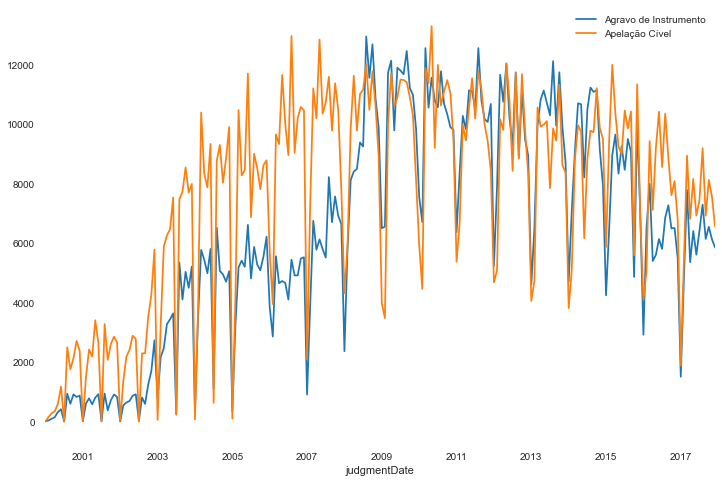

In [16]:
dfVAR.plot(figsize=figsize)

In [17]:
pd.DataFrame(adf_teste(dfVAR[dfUniqueTypes[0]]),adf_teste(dfVAR[dfUniqueTypes[1]]))
dfVarDiff = dfVAR.diff()

In [18]:
pd.DataFrame(adf_teste(dfVarDiff[dfUniqueTypes[0]]),adf_teste(dfVarDiff[dfUniqueTypes[1]]))

0
0.00021927658041478922                                                                      0.0316036
                                                                                                     
-4.473741054318497                                                                           -3.03673
13                                                                                                 13
201                                                                                               201
{'1%': -3.4633090972761744, '5%': -2.8760293320...  {'1%': -3.4633090972761744, '5%': -2.876029332...
3516.722786393653                                                                             3401.11
Strong evidence against the null hypothesis \n ...  Strong evidence against the null hypothesis \n...

In [19]:
dfVarDiff = dfVAR.diff().dropna()
dfVarDiff.shape

(215, 2)

In [20]:
#um of obs
nobs =12

In [21]:
train = dfVarDiff[:-nobs]
test = dfVarDiff[-nobs:]

In [22]:
#GRID SEARCH - FOR ORDER p AR of VAR MODEL
model = VAR(train)
print(train.count())

Agravo de Instrumento    203
Apelação Cível           203
dtype: int64


In [23]:
minVal = 99999
pMin=1000000

for p in np.arange(1,67):        
    results = model.fit(p)
    #print(f'ORDER {p}')
    #print(f'AIC {results.aic}\n')
    if minVal > results.aic:
        minVal = results.aic
        pMin = p

print(f'menor aic {minVal} no ORDER: {pMin}')



menor aic 25.061786808206243 no ORDER: 66


In [24]:
results = model.fit(66)
#results.summary()
print(train.values[-66:].shape)
lagged_value = train.values[-66:]
#rint(lagged_value)
z = results.forecast(y=lagged_value,steps=12)
print(test)

(66, 2)
              Agravo de Instrumento  Apelação Cível
judgmentDate                                       
2017-01-01                  -3989.0         -4894.0
2017-02-01                   3289.0          3546.0
2017-03-01                   2980.0          3502.0
2017-04-01                  -2422.0         -2122.0
2017-05-01                   1046.0          1341.0
2017-06-01                   -795.0         -1228.0
2017-07-01                    814.0           528.0
2017-08-01                    868.0          1734.0
2017-09-01                  -1153.0         -2265.0
2017-10-01                    407.0          1199.0
2017-11-01                   -414.0          -555.0
2017-12-01                   -283.0         -1017.0


In [25]:
idx = pd.date_range('2017-01-01',periods=12,freq='MS')

In [26]:
dfForecast = pd.DataFrame(data=z,index=idx,columns=['Agravo de Instrumento_2d','Apelação Cível_2d'])

In [27]:
dfForecast['Agravo de Instrumento_1d'] = (dfVarDiff['Agravo de Instrumento'].iloc[-nobs-1]-dfVarDiff['Agravo de Instrumento'].iloc[-nobs-2]) +dfForecast['Agravo de Instrumento_2d'].cumsum()
dfForecast['Agravo de Instrumento Forecast'] = dfVarDiff['Agravo de Instrumento'].iloc[-nobs-1] + dfForecast['Agravo de Instrumento_1d'].cumsum()

In [28]:
dfForecast['Apelação Cível_1d'] = (dfVarDiff['Apelação Cível'].iloc[-nobs-1]-dfVarDiff['Apelação Cível'].iloc[-nobs-2]) +dfForecast['Apelação Cível_2d'].cumsum()
dfForecast['Apelação Cível Forecast'] = dfVarDiff['Apelação Cível'].iloc[-nobs-1] + dfForecast['Apelação Cível_1d'].cumsum()

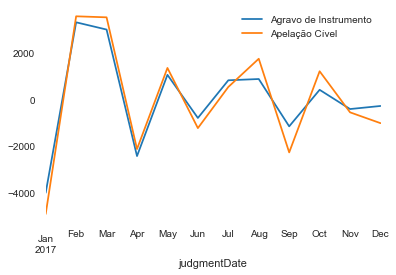

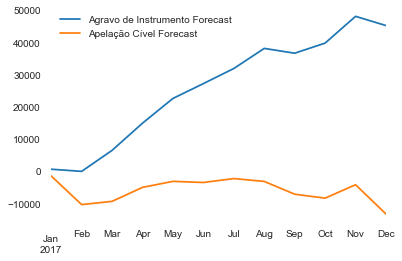

In [29]:
test_range = dfVarDiff[-nobs:]
#display(test_range)
test_range.plot()
#print(dfForecast.columns)
dfForecast[['Agravo de Instrumento Forecast','Apelação Cível Forecast']].plot()
#dfForecast.plot(figsize=figsize)
#dfVarDiff.plot()

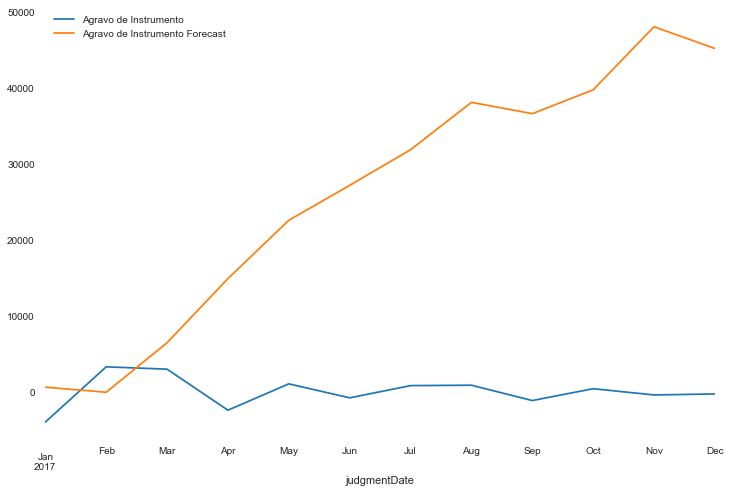

In [30]:
test_range['Agravo de Instrumento'].plot(legend=True,figsize=figsize)
dfForecast['Agravo de Instrumento Forecast'].plot(legend=True)


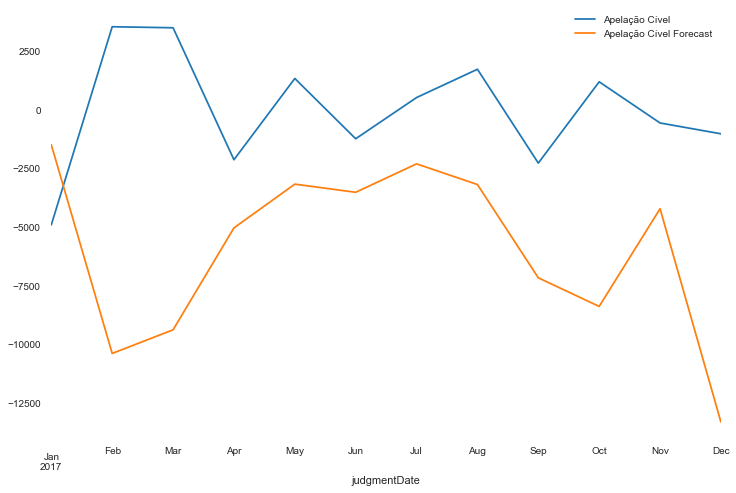

In [31]:
test_range['Apelação Cível'].plot(legend=True,figsize=figsize)
dfForecast['Apelação Cível Forecast'].plot(legend=True)

In [32]:
print(rmse(test_range['Apelação Cível'],dfForecast['Apelação Cível Forecast']),test_range['Apelação Cível'].mean())
print(rmse(test_range['Agravo de Instrumento'],dfForecast['Agravo de Instrumento Forecast']),test_range['Agravo de Instrumento'].mean())

7729.84612562276 -19.25
30751.626588409235 29.0


In [33]:
#retirar duplicados 
uniqueTypesComparison = []
for i in dfUniqueTypes:
    for i1 in dfUniqueTypes:
        if i != i1:
            if {i1,i} not in uniqueTypesComparison:
                uniqueTypesComparison.append({i,i1})
            

print(len(uniqueTypesComparison))
#display(uniqueTypesComparison)

7021


In [34]:
'non-stationary' in 'Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary'

True

274839  420127
Apelação Crime Agravo
pegando: 9
lag_order: 9
Apelação Crime VAR(9) RMSE: 9811.174
Agravo VAR(9) RMSE: 23384.861

comparar com AR model
Lag: 9
Coefficients:
const                95.726907
L1.Apelação Crime    -0.384772
L2.Apelação Crime    -0.473210
L3.Apelação Crime    -0.276637
L4.Apelação Crime     0.177918
L5.Apelação Crime    -0.132343
L6.Apelação Crime    -0.170692
L7.Apelação Crime    -0.408473
L8.Apelação Crime     0.062320
L9.Apelação Crime    -0.170454
dtype: float64
Lag: 5
Coefficients:
const        167.159362
L1.Agravo     -0.307064
L2.Agravo     -0.252341
L3.Agravo     -0.205897
L4.Agravo      0.560791
L5.Agravo     -0.073331
dtype: float64
Agravo VAR(9) RMSE: 23384.861
Agravo  AR(9) RMSE: 3142.568
Apelação Crime VAR(9) RMSE: 9811.174
Apelação Crime  AR(9) RMSE: 8947.358
Apelação Crime SARIMAX((3, 0, 2)) RMSE Error: 933.3330911

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1545  , p=0.2881  , df_denom=47, df_num=1
ssr based chi2

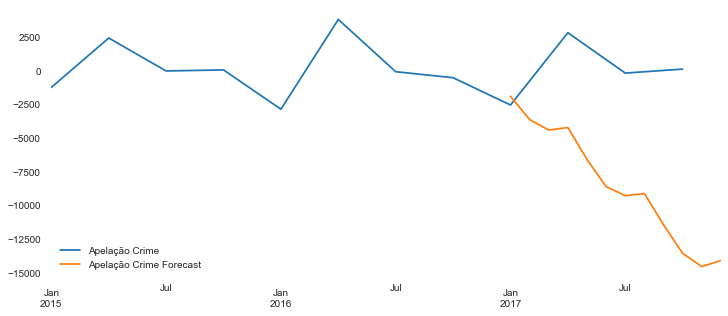

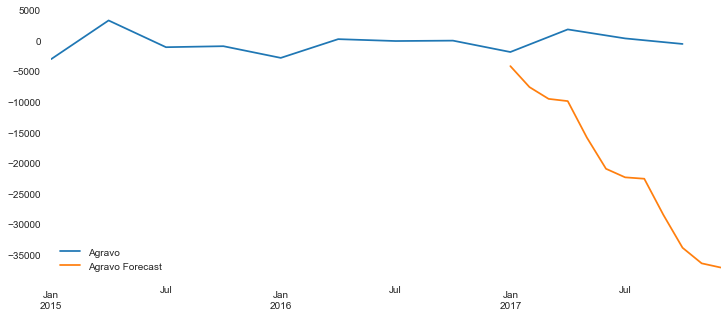

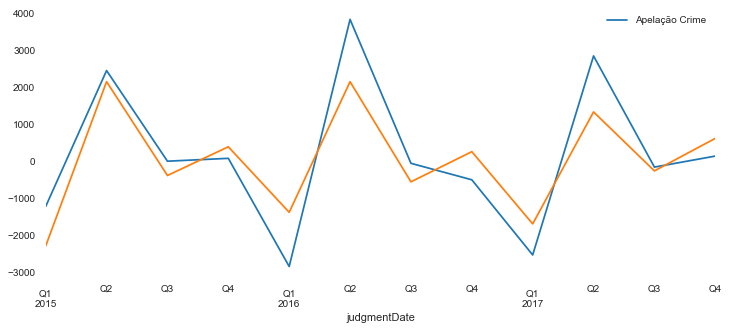

-------------


In [37]:
for i,i1 in uniqueTypesComparison[:1]:
    try:
        
        i1= 'Agravo'
        i='Apelação Crime'
        
        if(TooDifferent(i,i1)):
            print('pulando series muito diferentes',i,i1)
            break

        
        dfMonthAlt = dfQuarter['2005-01-01':].copy()
        
        dfMonth1 = dfMonthAlt[[i]]
        dfMonth2 = dfMonthAlt[[i1]]
        steps=12
      
        while(('non-stationary' in adf_teste(dfMonth1)[7]) or ('non-stationary' in adf_teste(dfMonth2)[7])):
            dfMonth1 = dfMonth1.diff()
            dfMonth2 = dfMonth2.diff()
            
        dfMonth1 = dfMonth1.dropna()
        dfMonth2 = dfMonth2.dropna()
        
        #dfMonthAlt = dfMonthAlt[['judgmentDate']]
        
        dfMonthAlt = pd.merge(dfMonth1,dfMonth2,on='judgmentDate')
        
        
        #display(dfMonthAlt.head())
        #display(dfMonth1.head())
        #display(dfMonth2.head())
                 
        #display(dfMonthAlt)
        
        #dfMonthAlt = dfMonthAlt['2012-01-01':]        
        
        print(i,i1)             
        dfVAR = dfMonthAlt[[i,i1]]        
        #dfVarDiff = dfVAR.diff().dropna()       
        
        #numero de observações        
        nobs =steps        
        train = dfVAR[:-nobs]
        test = dfVAR[-nobs:]
        
        #Aplica VAR Model
        model = VAR(train)
        #print('Train count: ',train.count())
        #print('test count: ',test.count())
        #display(train)
        #display(test)

        
        minVal = 99999
        pMin=1000000
        
        try:
            for p in np.arange(1,10):                   
                results = model.fit(p)            
                if minVal > results.aic:
                    minVal = results.aic
                    pMin = p
            print('pegando:',pMin)
        except:            
            if pMin == 1000000:                
                pMin =0
            print('Erro - pegando:',pMin)
        
                     
        results = model.fit(pMin)        
        lag_order = results.k_ar
        print('lag_order: '+ str(lag_order))
        
        
        z = results.forecast(y=train.values[-lag_order:],steps=steps)       
        idx = pd.date_range('2017-01-01',periods=steps,freq='MS')        
        dfForecast = pd.DataFrame(data=z,index=idx,columns=[i+'_2d',i1+'_2d'])
        
        dfForecast[i+'_1d'] = (dfVAR[i].iloc[-nobs-1]-dfVAR[i].iloc[-nobs-2]) +dfForecast[i+'_2d'].cumsum()
        dfForecast[i+' Forecast'] = dfVAR[i].iloc[-nobs-1] + dfForecast[i+'_1d'].cumsum()
        
        dfForecast[i1+'_1d'] = (dfVAR[i1].iloc[-nobs-1]-dfVAR[i1].iloc[-nobs-2]) +dfForecast[i1+'_2d'].cumsum()
        dfForecast[i1+' Forecast'] = dfVAR[i1].iloc[-nobs-1] + dfForecast[i1+'_1d'].cumsum()
        
               
        dfVAR[[i]][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
        dfForecast[i+' Forecast'].plot(legend=True);
        
          
        dfVAR[[i1]][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
        dfForecast[i1+' Forecast'].plot(legend=True);
        
        RMSE1 = rmse(dfVAR[i][-nobs:], dfForecast[i+' Forecast'])
        print(f'{i} VAR({pMin}) RMSE: {RMSE1:.3f}')
        
        RMSE2 = rmse(dfVAR[i1][-nobs:], dfForecast[i1+' Forecast'])
        print(f'{i1} VAR({pMin}) RMSE: {RMSE2:.3f}')

       
        #comparar com AR model
        print('\ncomparar com AR model')
        from statsmodels.tsa.ar_model import AR,ARResults
        
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        

        modelM = AR(train[i])
        ARfit1 = modelM.fit(maxlag=pMin,method='mle')
        print(f'Lag: {ARfit1.k_ar}')
        print(f'Coefficients:\n{ARfit1.params}')
        
        start=len(train)
        end=len(train)+len(test)-1
        z1 = pd.DataFrame(ARfit1.predict(start=start, end=end, dynamic=False),columns=[i])
   
        #INVERTER
        z1[i+'_1d'] = (dfVAR[i].iloc[-nobs-1]-dfVAR[i].iloc[-nobs-2]) + z1[i].cumsum()        
        z1[i+' Forecast'] = dfVAR[i].iloc[-nobs-1] + z1[i+'_1d'].cumsum()
        RMSE3 = rmse(dfVAR[i][-nobs:], z1[i+' Forecast'])

        
               
        modelS = AR(train[i1])
        ARfit2 = modelS.fit(maxlag=5,method='mle')
        print(f'Lag: {ARfit2.k_ar}')
        print(f'Coefficients:\n{ARfit2.params}')
        
        z2 = pd.DataFrame(ARfit2.predict(start=start, end=end, dynamic=False),columns=[i1])
       
        
        z2[i1+'_1d'] = (dfVAR[i].iloc[-nobs-1]-dfVAR[i1].iloc[-nobs-2]) + z2[i1].cumsum()
        z2[i1+' Forecast'] = dfVAR[i].iloc[-nobs-1] + z2[i1+'_1d'].cumsum()
        
        RMSE4 = rmse(dfVAR[i1][-nobs:], z2[i1+' Forecast'])

        print(f'{i1} VAR({pMin}) RMSE: {RMSE2:.3f}')
        print(f'{i1}  AR({pMin}) RMSE: {RMSE4:.3f}')
        
        autoArimaResults = auto_arima(dfVAR[i],seasonal=True,m=steps,trace=False)
        modelSARIMAX = SARIMAX(train[i],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order)
        resultsSarimax = modelSARIMAX.fit()
        predictionsSarimax = resultsSarimax.predict(start=start, end=end, typ='levels').rename(f'SARIMAX({autoArimaResults.order}{autoArimaResults.seasonal_order}) Predictions')
        error = rmse(test[i], predictionsSarimax)
        
        print(f'{i} VAR({pMin}) RMSE: {RMSE1:.3f}')
        print(f'{i}  AR({pMin}) RMSE: {RMSE3:.3f}')
        print(f'{i} SARIMAX({autoArimaResults.order}) RMSE Error: {error:11.10}')
        
        
        dfVAR[[i]][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
        predictionsSarimax.plot()
        
        grangercausalitytests(dfVAR,maxlag=steps)
        
        plt.show()
        
        #print('RMSE '+ i+ ' ' + str(rmse(test_range[i],dfForecast[i+' Forecast'])),test_range[i].mean())
        #print('RMSE '+ i1+ ' ' + str(rmse(test_range[i1],dfForecast[i1 + ' Forecast'])),test_range[i1].mean())
        
        #break
        print('-------------')
    except w:
        print(f'ERRo {i},{i1}')
            

In [38]:
#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
    
from statsmodels.tsa.stattools import grangercausalitytests

#dfAPAG = df_count_year_month_type[(df_count_year_month_type['type'] == 'Apelação e Reexame Necessário') | (df_count_year_month_type['type'] == 'Agravo Regimental')
#                                 | (df_count_year_month_type['type'] == 'Ação Rescisória') 
#                                  | (df_count_year_month_type['type'] == 'Mandado de Segurança')]
#
#
#import plotly.express as px
#fig = px.line(dfAPAG.reset_index(), x='yearMonth', y='count', color='type')
#fig.show()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2887  , p=0.5970  , df_denom=20, df_num=1
ssr based chi2 test:   chi2=0.3320  , p=0.5645  , df=1
likelihood ratio test: chi2=0.3297  , p=0.5659  , df=1
parameter F test:         F=0.2887  , p=0.5970  , df_denom=20, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0757  , p=0.9274  , df_denom=17, df_num=2
ssr based chi2 test:   chi2=0.1961  , p=0.9066  , df=2
likelihood ratio test: chi2=0.1952  , p=0.9070  , df=2
parameter F test:         F=0.0757  , p=0.9274  , df_denom=17, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9304  , p=0.4519  , df_denom=14, df_num=3
ssr based chi2 test:   chi2=4.1869  , p=0.2420  , df=3
likelihood ratio test: chi2=3.8178  , p=0.2818  , df=3
parameter F test:         F=0.9304  , p=0.4519  , df_denom=14, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5587  , p=0.6974  , df_d

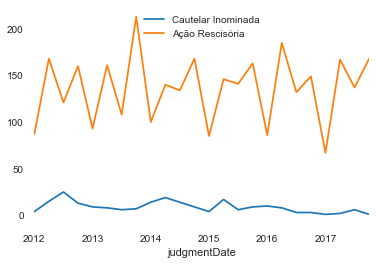

In [39]:
#grangercausalitytests(dfMonth[['Agravo de Instrumento','Apelação Cível']],maxlag=6);
#dfMonth[['Agravo de Instrumento','Apelação Cível']].plot()

#grangercausalitytests(dfMonth[['Agravo de Instrumento','Ação Rescisória']],maxlag=12);
#dfMonth[['Agravo de Instrumento','Ação Rescisória']].plot()

df = dfQuarter.copy()
df = df['2012-01-01':]

item1= 'Cautelar Inominada'
item2='Ação Rescisória'

grangercausalitytests(df[[item1,item2]],maxlag=6);
df[[item1,item2]].plot()



In [40]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [41]:
dfMonth[dfMonth['Ação Rescisória']!=0][['Ação Rescisória']].count().item()

205

In [42]:
dfMonth['Ação Rescisória'].dropna().count()/12

18.0

# VERSAO ALTERNATIVA NOVA - MELHOR

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [892]:
print(str(dfListOfTypes).replace("' '","','"))

dfVAR2 = dfQuarter[['Apelação Cível', 'Agravo de Instrumento','Embargos de Declaração'
                    , 'Recurso Cível', 'Agravo','Apelação Crime',
                   'Habeas Corpus','Apelação e Reexame Necessário','Reexame Necessário','Recurso Crime']]

['total','Apelação Cível','Agravo de Instrumento','Embargos de Declaração'
 'Recurso Cível','Agravo','Apelação Crime','Habeas Corpus'
 'Apelação e Reexame Necessário','Reexame Necessário','Recurso Crime'
 'Conflito de Competência','Recurso em Sentido Estrito'
 'Agravo Regimental','Mandado de Segurança'
 'Embargos Infringentes e de Nulidade','weekDay','Embargos Infringentes'
 'Ação Rescisória','Revisão Criminal','Correição Parcial'
 'Conflito de Jurisdição','Feriado','Mandado de Injunção','Agravo Interno'
 'weekType','Ação Direta de Inconstitucionalidade','Petição'
 'Exceção de Suspeição','Mandado de Segurança Crime'
 'Incidente de Uniformizacao Jurisprudencia','Carta Testemunhável'
 'Representação Criminal','Recurso de Ofício','Cautelar Inominada'
 'Ação Penal','Uniformização de Jurisprudência','Termo Circunstanciado'
 'Restauração de Autos','Medida Cautelar Inominada','Medida Cautelar'
 'Desaforamento','Crimes contra a honra'
 'Incidente de Inconstitucionalidade'
 'Impugnação à Assist

In [893]:
#dfVAR2.plot()

In [894]:
dfVAR2 = dfVAR2['2005-01-01':] #Antes de 2005 alguns valores pareciam se quer existir

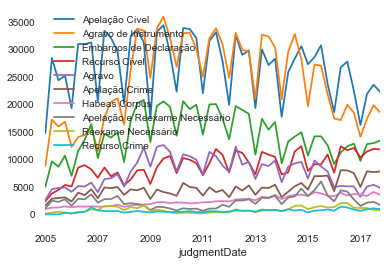

In [895]:
dfVAR2.plot()

In [896]:
print(dfVAR2.shape)

(52, 10)


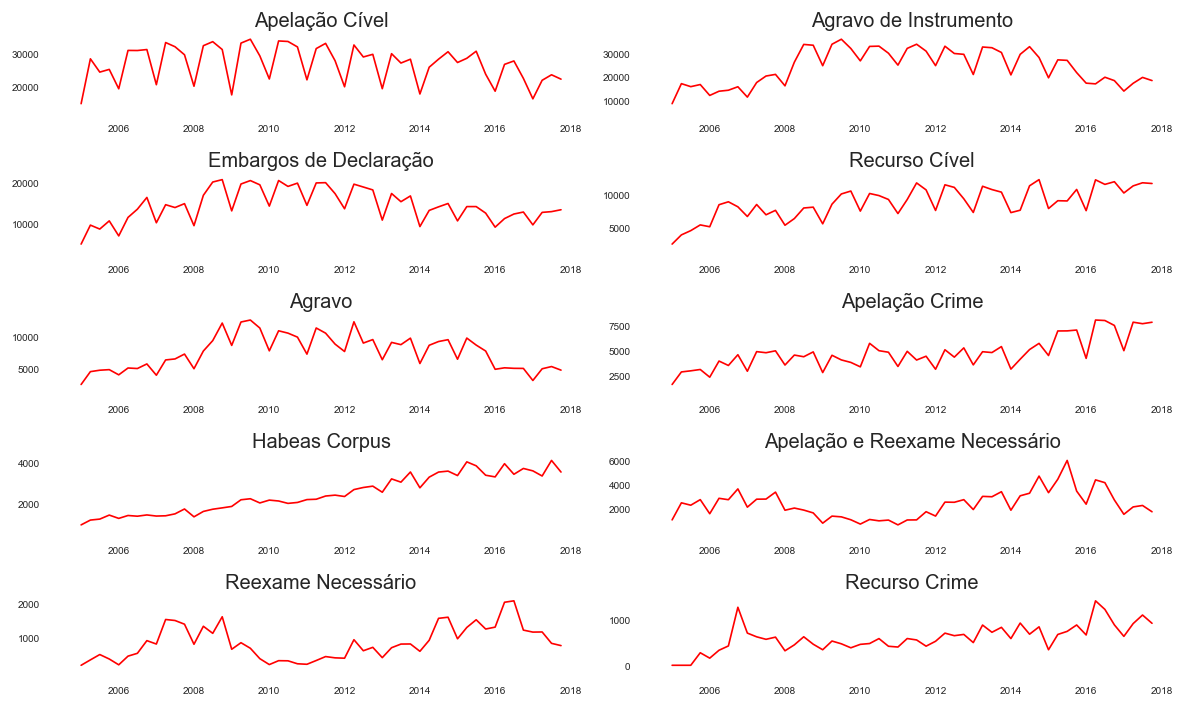

In [902]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = dfVAR2[dfVAR2.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dfVAR2.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [903]:
#dfVAR2.columns

In [904]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            #print(r,c)
            #TooDifferent
            #if TooDifferent(r,c):
            #    print('tirando {r} e {c}')                
            #else:                
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#dfListOfTypes

dfCorrelationGrangerMatrix = grangers_causation_matrix(dfVAR2, variables = dfVAR2.columns) 

In [905]:
dfCorrelationGrangerMatrix

Apelação Cível_x  Agravo de Instrumento_x  \
Apelação Cível_y                           1.0000                   0.0763   
Agravo de Instrumento_y                    0.0000                   1.0000   
Embargos de Declaração_y                   0.0000                   0.0010   
Recurso Cível_y                            0.0000                   0.0000   
Agravo_y                                   0.0000                   0.0000   
Apelação Crime_y                           0.0000                   0.0000   
Habeas Corpus_y                            0.0095                   0.0000   
Apelação e Reexame Necessário_y            0.0004                   0.0000   
Reexame Necessário_y                       0.0000                   0.0002   
Recurso Crime_y                            0.0000                   0.0000   

                                 Embargos de Declaração_x  Recurso Cível_x  \
Apelação Cível_y                                   0.0123           0.0006   
Agravo de Instrumento_y                            0.0000           0.0000   
Embargos de Declaração_y                           1.0000           0.0010   
Recurso Cível_y                                    0.0000           1.0000   
Agravo_y                                           0.0000           0.0000   
Apelação Crime_y                                   0.0000           0.0000   
Habeas Corpus_y                                    0.0000           0.0000   
Apelação e Reexame Necessário_y                    0.0000           0.0000   
Reexame Necessário_y                               0.0000           0.0002   
Recurso Crime_y                                    0.0001           0.0028   

                                 Agravo_x  Apelação Crime_x  Habeas Corpus_x  \
Apelação Cível_y                   0.0366            0.0000           0.0002   
Agravo de Instrumento_y            0.0000            0.0000           0.0000   
Embargos de Declaração_y           0.0344            0.0002           0.0001   
Recurso Cível_y                    0.0000            0.0000           0.0000   
Agravo_y                           1.0000            0.0000           0.0034   
Apelação Crime_y                   0.0001            1.0000           0.0001   
Habeas Corpus_y                    0.0000            0.0000           1.0000   
Apelação e Reexame Necessário_y    0.0069            0.0000           0.0000   
Reexame Necessário_y               0.0001            0.0000           0.0000   
Recurso Crime_y                    0.0000            0.0000           0.0000   

                                 Apelação e Reexame Necessário_x  \
Apelação Cível_y                                          0.0135   
Agravo de Instrumento_y                                   0.0000   
Embargos de Declaração_y                                  0.0001   
Recurso Cível_y                                           0.0003   
Agravo_y                                                  0.0007   
Apelação Crime_y                                          0.0000   
Habeas Corpus_y                                           0.0000   
Apelação e Reexame Necessário_y                           1.0000   
Reexame Necessário_y                                      0.0000   
Recurso Crime_y                                           0.0000   

                                 Reexame Necessário_x  Recurso Crime_x  
Apelação Cível_y                               0.0930           0.0000  
Agravo de Instrumento_y                        0.0002           0.0059  
Embargos de Declaração_y                       0.0452           0.0103  
Recurso Cível_y                                0.0797           0.0375  
Agravo_y                                       0.0005           0.0002  
Apelação Crime_y                               0.0000           0.2572  
Habeas Corpus_y                                0.1974           0.0257  
Apelação e Reexame Necessário_y                0.0149           0.0285  
Reexame Necessário_y        

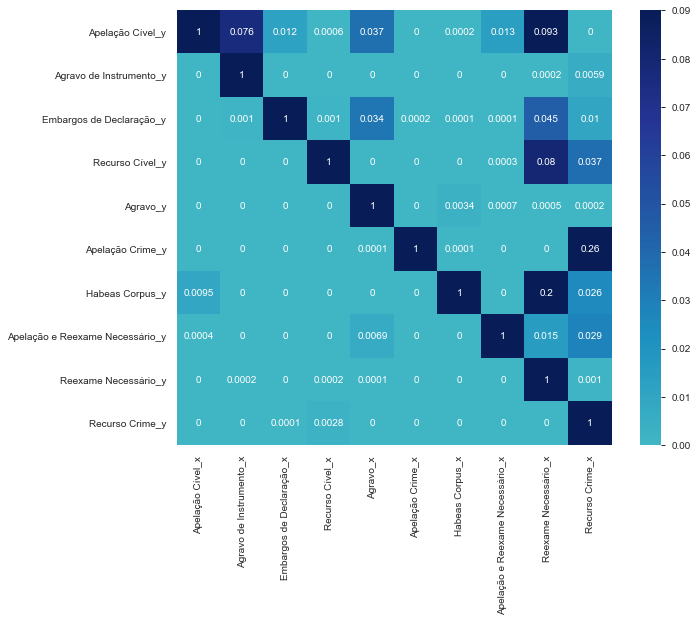

In [906]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(dfCorrelationGrangerMatrix, 
            xticklabels=dfCorrelationGrangerMatrix.columns.values,
            yticklabels=dfCorrelationGrangerMatrix.index.values,center=0,vmax=.09,square=True,cmap="YlGnBu",annot=True) 

In [907]:
import plotly.graph_objects as go

fig = go.Figure()

for i in dfVAR2.columns:
    fig.add_trace(go.Scatter(x=dfVAR2.reset_index()['judgmentDate'], y=dfVAR2[i],
                    mode='lines',
                    name=i))
fig.show()

In [912]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def adjust(val, length= 6): return str(val).ljust(length)


def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col,35), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dfVAR2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Apelação Cível                      ::  565.38    > 219.4051  =>   True
Agravo de Instrumento               ::  376.82    > 179.5199  =>   True
Embargos de Declaração              ::  209.13    > 143.6691  =>   True
Recurso Cível                       ::  130.17    > 111.7797  =>   True
Agravo                              ::  81.13     > 83.9383   =>   False
Apelação Crime                      ::  49.58     > 60.0627   =>   False
Habeas Corpus                       ::  24.46     > 40.1749   =>   False
Apelação e Reexame Necessário       ::  8.24      > 24.2761   =>   False
Reexame Necessário                  ::  3.32      > 12.3212   =>   False
Recurso Crime                       ::  1.0       > 4.1296    =>   False


In [913]:
nobs = 12
dfVAR2_train, dfVAR2_test = dfVAR2[0:-nobs], dfVAR2[-nobs:]

# Check size
print(dfVAR2_train.shape)  # (119, 8)
print(dfVAR2_test.shape)  # (4, 8)

(40, 10)
(12, 10)


In [914]:
dfVAR2_test

Apelação Cível  Agravo de Instrumento  Embargos de Declaração  \
judgmentDate                                                                  
2015-01-01             27271                  19660                   10672   
2015-04-01             28551                  27211                   14170   
2015-07-01             30701                  26998                   14172   
2015-10-01             23713                  21841                   12572   
2016-01-01             18550                  17410                    9134   
2016-04-01             26705                  17113                   11234   
2016-07-01             27743                  19906                   12351   
2016-10-01             22449                  18476                   12838   
2017-01-01             16231                  14070                    9695   
2017-04-01             21869                  17350                   12752   
2017-07-01             23541                  19831                   12939   
2017-10-01             22215                  18503                   13399   

              Recurso Cível  Agravo  Apelação Crime  Habeas Corpus  \
judgmentDate                                                         
2015-01-01             7891    6508            4489           3356   
2015-04-01             9108    9790            6939           4018   
2015-07-01             9073    8703            6947           3827   
2015-10-01            10864    7779            7032           3372   
2016-01-01             7563    4945            4203           3292   
2016-04-01            12359    5173            8031           3929   
2016-07-01            11649    5094            7982           3418   
2016-10-01            12064    5080            7489           3699   
2017-01-01            10312    3206            4971           3583   
2017-04-01            11415    5023            7815           3335   
2017-07-01            11899    5370            7664           4087   
2017-10-01            11787    4814            7810           3526   

              Apelação e Reexame Necessário  Reexame Necessário  Recurso Crime  
judgmentDate                                                                    
2015-01-01                             3307                 952            342  
2015-04-01                             4416                1292            679  
2015-07-01                             5967                1523            747  
2015-10-01                             3437                1245            888  
2016-01-01                             2360                1302            668  
2016-04-01                             4363                2048           1420  
2016-07-01                             4133                2091           1231  
2016-10-01                             2704                1213            890  
2017-01-01                             1524                1153            637  
2017-04-01                             2133                1157            918  
2017-07-01                             2253                 816           1107  
2017-10-01                             1735                 748            925

In [915]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    #print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    #print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    #print(f' Significance Level    = {signif}')
    #print(f' Test Statistic        = {output["test_statistic"]}')
    #print(f' No. Lags Chosen       = {output["n_lags"]}')

    #for key,val in r[4].items():
    #    print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
    #    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
        return(True)
    else:
      #  print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    
        return(False)
        

In [916]:
for name, column in dfVAR2_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

 => Series is Non-Stationary.


 => Series is Non-Stationary.


 => Series is Non-Stationary.


 => Series is Non-Stationary.


 => Series is Non-Stationary.


 => Series is Stationary.


 => Series is Non-Stationary.


 => Series is Non-Stationary.


 => Series is Non-Stationary.


 => Series is Stationary.




In [917]:
df_differenced = dfVAR2_train#.diff().dropna()
countDiff = 0
regra = True
#atleastOne = False

while(regra):    
    for name, column in df_differenced.iteritems():
        atleastOne = False
        if (adfuller_test(column, name=column.name) != True):
            atleastOne = True
        
        if atleastOne:
            countDiff = countDiff + 1
            print(adfuller_test(column, name=column.name))
            df_differenced = df_differenced.diff().dropna()
            break
        else:
            regra=False
            
print(countDiff,df_differenced.shape)

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print(f'{name} \n')

 => Series is Non-Stationary.
 => Series is Non-Stationary.
False
 => Series is Stationary.
 => Series is Non-Stationary.
 => Series is Non-Stationary.
False
2 (38, 10)
 => Series is Stationary.
Apelação Cível 

 => Series is Stationary.
Agravo de Instrumento 

 => Series is Stationary.
Embargos de Declaração 

 => Series is Stationary.
Recurso Cível 

 => Series is Stationary.
Agravo 

 => Series is Stationary.
Apelação Crime 

 => Series is Stationary.
Habeas Corpus 

 => Series is Stationary.
Apelação e Reexame Necessário 

 => Series is Stationary.
Reexame Necessário 

 => Series is Stationary.
Recurso Crime 



In [919]:
print(df_differenced.shape)

model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    try:
        result = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        print('erro, \n')
        continue

model.select_order(2).summary()

(38, 10)
Lag Order = 1
AIC :  133.7213357504417
BIC :  138.51055116641103
FPE :  1.428320301741628e+58
HQIC:  135.40975850935936 

Lag Order = 2
AIC :  125.07313262275126
BIC :  134.3103264304119
FPE :  1.1210844869511777e+55
HQIC:  128.29716067174832 

Lag Order = 3
erro, 

Lag Order = 4
AIC :  -504.52638461191384
BIC :  -486.1202724033072
FPE :  5.1575849282170205e-220
HQIC:  -498.24937321462045 

Lag Order = 5
AIC :  -501.698520263999
BIC :  -478.57067613224433
FPE :  2.40725034400466e-225
HQIC:  -493.9167044047311 

Lag Order = 6
AIC :  -494.52199728384517
BIC :  -466.5814066367254
FPE :  5.434977917084676e-227
HQIC:  -485.260481969471 

Lag Order = 7
AIC :  -488.1686076017464
BIC :  -455.3256748538608
FPE :  1.4553924359642873e-228
HQIC:  -477.4626304531373 

Lag Order = 8
AIC :  -482.3125714285511
BIC :  -444.4802421236729
FPE :  2.8836176834751406e-230
HQIC:  -470.20968423066785 

Lag Order = 9
AIC :  -473.3450724604831
BIC :  -430.4402722781489
FPE :  1.099056204781044e-230
HQI

<class 'statsmodels.iolib.table.SimpleTable'>

In [920]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, May, 2020
Time:                     15:29:34
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    134.310
Nobs:                     36.0000    HQIC:                   128.297
Log likelihood:          -2552.13    FPE:                1.12108e+55
AIC:                      125.073    Det(Omega_mle):     1.13218e+53
--------------------------------------------------------------------
Results for equation Apelação Cível
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                 -142.106070      1085.098684           -0.131           0.896
L1.Apelação Cível                        1.758899         1.003839         

In [921]:
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation,
#and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dfVAR2.columns, out):
    detail = ""
    if  round(val, 2) > 2:
        detail = "Negative Serial Correlation"
    else:
        detail = "Positive Serial Correlation"
    print((adjust(col)+':').ljust(30, ' '), round(val, 2), ' ' + detail)

Apelação Cível:                1.87  Positive Serial Correlation
Agravo de Instrumento:         1.89  Positive Serial Correlation
Embargos de Declaração:        1.63  Positive Serial Correlation
Recurso Cível:                 1.47  Positive Serial Correlation
Agravo:                        1.74  Positive Serial Correlation
Apelação Crime:                1.93  Positive Serial Correlation
Habeas Corpus:                 1.98  Positive Serial Correlation
Apelação e Reexame Necessário: 1.84  Positive Serial Correlation
Reexame Necessário:            2.07  Negative Serial Correlation
Recurso Crime:                 2.01  Negative Serial Correlation


In [922]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

2


array([[-5682., -5424., -3083.,  3423., -2250.,   -26.,  -268.,  -973.,
          327.,  -587.],
       [ -195., -7797.,   -55., -2836.,  -296.,  -346.,  -200.,  1199.,
         -625.,   407.]])

In [923]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
print(dfVAR2.shape,fc.shape)
df_forecast = pd.DataFrame(fc, index=dfVAR2.index[-nobs:], columns=dfVAR2.columns + '_2d')
df_forecast

(52, 10) (12, 10)


Apelação Cível_2d  Agravo de Instrumento_2d  \
judgmentDate                                                
2015-01-01        -12471.959964             -10679.541430   
2015-04-01          4691.610135               9717.014440   
2015-07-01            56.926383               3568.391899   
2015-10-01          2991.692996              -8079.631144   
2016-01-01         -9311.112320              -5960.002790   
2016-04-01          8674.877343               9003.883562   
2016-07-01         -9183.929713               -660.895007   
2016-10-01          7479.745456              -3195.921970   
2017-01-01         -5273.649363              -3799.286763   
2017-04-01          7612.418612               6393.698567   
2017-07-01        -13079.011599              -3207.036638   
2017-10-01          9004.405197                227.048712   

              Embargos de Declaração_2d  Recurso Cível_2d    Agravo_2d  \
judgmentDate                                                             
2015-01-01                 -6316.423836      -2529.758838 -1672.989106   
2015-04-01                  5446.309741       1857.909071 -1178.128046   
2015-07-01                   302.697681        672.665228  3836.490453   
2015-10-01                  -986.770858        495.244634  -541.080582   
2016-01-01                 -4119.831943      -1947.435480 -3343.626821   
2016-04-01                  6144.169491        210.619085  1741.687626   
2016-07-01                 -3630.033612         95.019715   712.491678   
2016-10-01                  1323.037760       2325.320440   234.042116   
2017-01-01                 -3227.715593      -3444.667899 -2275.689723   
2017-04-01                  6311.105302       2210.430471  2597.677578   
2017-07-01                 -6265.243411      -1459.176653 -2316.525334   
2017-10-01                  3307.239132       1389.294872  1993.170701   

              Apelação Crime_2d  Habeas Corpus_2d  \
judgmentDate                                        
2015-01-01         -1947.284793       -476.642009   
2015-04-01           734.733663        720.751344   
2015-07-01           909.642728        -69.747333   
2015-10-01           442.744406       -203.170557   
2016-01-01         -2405.821042       -163.407850   
2016-04-01          1848.065841        176.464660   
2016-07-01          -936.605126        224.425771   
2016-10-01          1268.997477       -220.637935   
2017-01-01         -1606.340180       -123.612910   
2017-04-01          1393.052231        154.108420   
2017-07-01         -1612.189361         32.791534   
2017-10-01          1762.848514         39.688115   

              Apelação e Reexame Necessário_2d  Reexame Necessário_2d  \
judgmentDate                                                            
2015-01-01                        -1760.870887             685.136492   
2015-04-01                         2233.014879            -372.229049   
2015-07-01                        -1368.907149             632.906040   
2015-10-01                          971.375853             -50.828541   
2016-01-01                        -1265.388153            -511.506613   
2016-04-01                         1682.296449             621.296428   
2016-07-01                        -1166.877044            -304.190821   
2016-10-01                          573.493784             396.113219   
2017-01-01                         -555.476729            -600.020286   
2017-04-01                         1021.745527             738.360149   
2017-07-01                         -789.441091            -641.967852   
2017-10-01                          346.529756             587.834897   

              Recurso Crime_2d  
judgmentDate                    
2015-01-01          -55.410458  
2015-04-01          727.342408  
2015-07-01         -485.301793  
2015-10-01           26.590968  
2016-01-01         -215.443446  
2016-04-01          875.308970  
2016-07-01         -546.368003  
2016-10-01         -111.899119  
2017-01-01            3.71

In [924]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [925]:
df_results = invert_transformation(dfVAR2_train, df_forecast, second_diff=True) 

colunas =[]
for i in df_results.columns:
    if 'forecast' in i:
        colunas.append(i)
print(colunas)

df_results.loc[:, colunas]

['Apelação Cível_forecast', 'Agravo de Instrumento_forecast', 'Embargos de Declaração_forecast', 'Recurso Cível_forecast', 'Agravo_forecast', 'Apelação Crime_forecast', 'Habeas Corpus_forecast', 'Apelação e Reexame Necessário_forecast', 'Reexame Necessário_forecast', 'Recurso Crime_forecast']


Apelação Cível_forecast  Agravo de Instrumento_forecast  \
judgmentDate                                                            
2015-01-01               20328.040036                    12947.458570   
2015-04-01               14803.690208                     7415.931580   
2015-07-01                9336.266762                     5452.796489   
2015-10-01                6860.536313                    -4589.969747   
2016-01-01               -4926.306457                   -20592.738773   
2016-04-01               -8038.271883                   -27591.624237   
2016-07-01              -20334.167022                   -35251.404708   
2016-10-01              -25150.316706                   -46107.107148   
2017-01-01              -35240.115752                   -60762.096352   
2017-04-01              -37717.496186                   -69023.386988   
2017-07-01              -53273.888218                   -80491.714262   
2017-10-01              -59825.875054                   -91732.992824   

              Embargos de Declaração_forecast  Recurso Cível_forecast  \
judgmentDate                                                            
2015-01-01                        9430.576164            10821.241162   
2015-04-01                        9379.462070            11110.391395   
2015-07-01                        9631.045656            12072.206856   
2015-10-01                        8895.858384            13529.266951   
2016-01-01                        4040.839170            13038.891566   
2016-04-01                        5329.989446            12759.135267   
2016-07-01                        2989.106110            12574.398682   
2016-10-01                        1971.260535            14714.982538   
2017-01-01                       -2274.300634            13410.898494   
2017-04-01                        -208.756500            14317.244922   
2017-07-01                       -4408.455777            13764.414696   
2017-10-01                       -5300.915923            14600.879342   

              Agravo_forecast  Apelação Crime_forecast  \
judgmentDate                                             
2015-01-01        8153.010894              4370.715207   
2015-04-01        5587.893743              3775.164077   
2015-07-01        6859.267044              4089.255675   
2015-10-01        7589.559763              4846.091680   
2016-01-01        4976.225661              3197.106642   
2016-04-01        4104.579185              3396.187446   
2016-07-01        3945.424387              2658.663123   
2016-10-01        4020.311705              3190.136278   
2017-01-01        1819.509300              2115.269253   
2017-04-01        2216.384472              2433.454459   
2017-07-01         296.734311              1139.450304   
2017-10-01         370.254850              1608.294663   

              Habeas Corpus_forecast  Apelação e Reexame Necessário_forecast  \
judgmentDate                                                                   
2015-01-01               3140.357991                             4326.129113   
2015-04-01               3430.467327                             6210.273104   
2015-07-01               3650.829330                             6725.509946   
2015-10-01               3668.020777                             8212.122641   
2016-01-01               3521.804373                             8433.347184   
2016-04-01               3552.052630                            10336.868174   
2016-07-01               3806.726658                            11073.512121   
2016-10-01               3840.762750                            12383.649852   
2017-01-01               3751.185932                            13138.310853   
2017-04-01               3815.717535                            14914.717382   
2017-07-01               3913.040672                            15901.682819   
2017-10-01               4050.051923                            17235.178012   

              Reexame Necessário_f

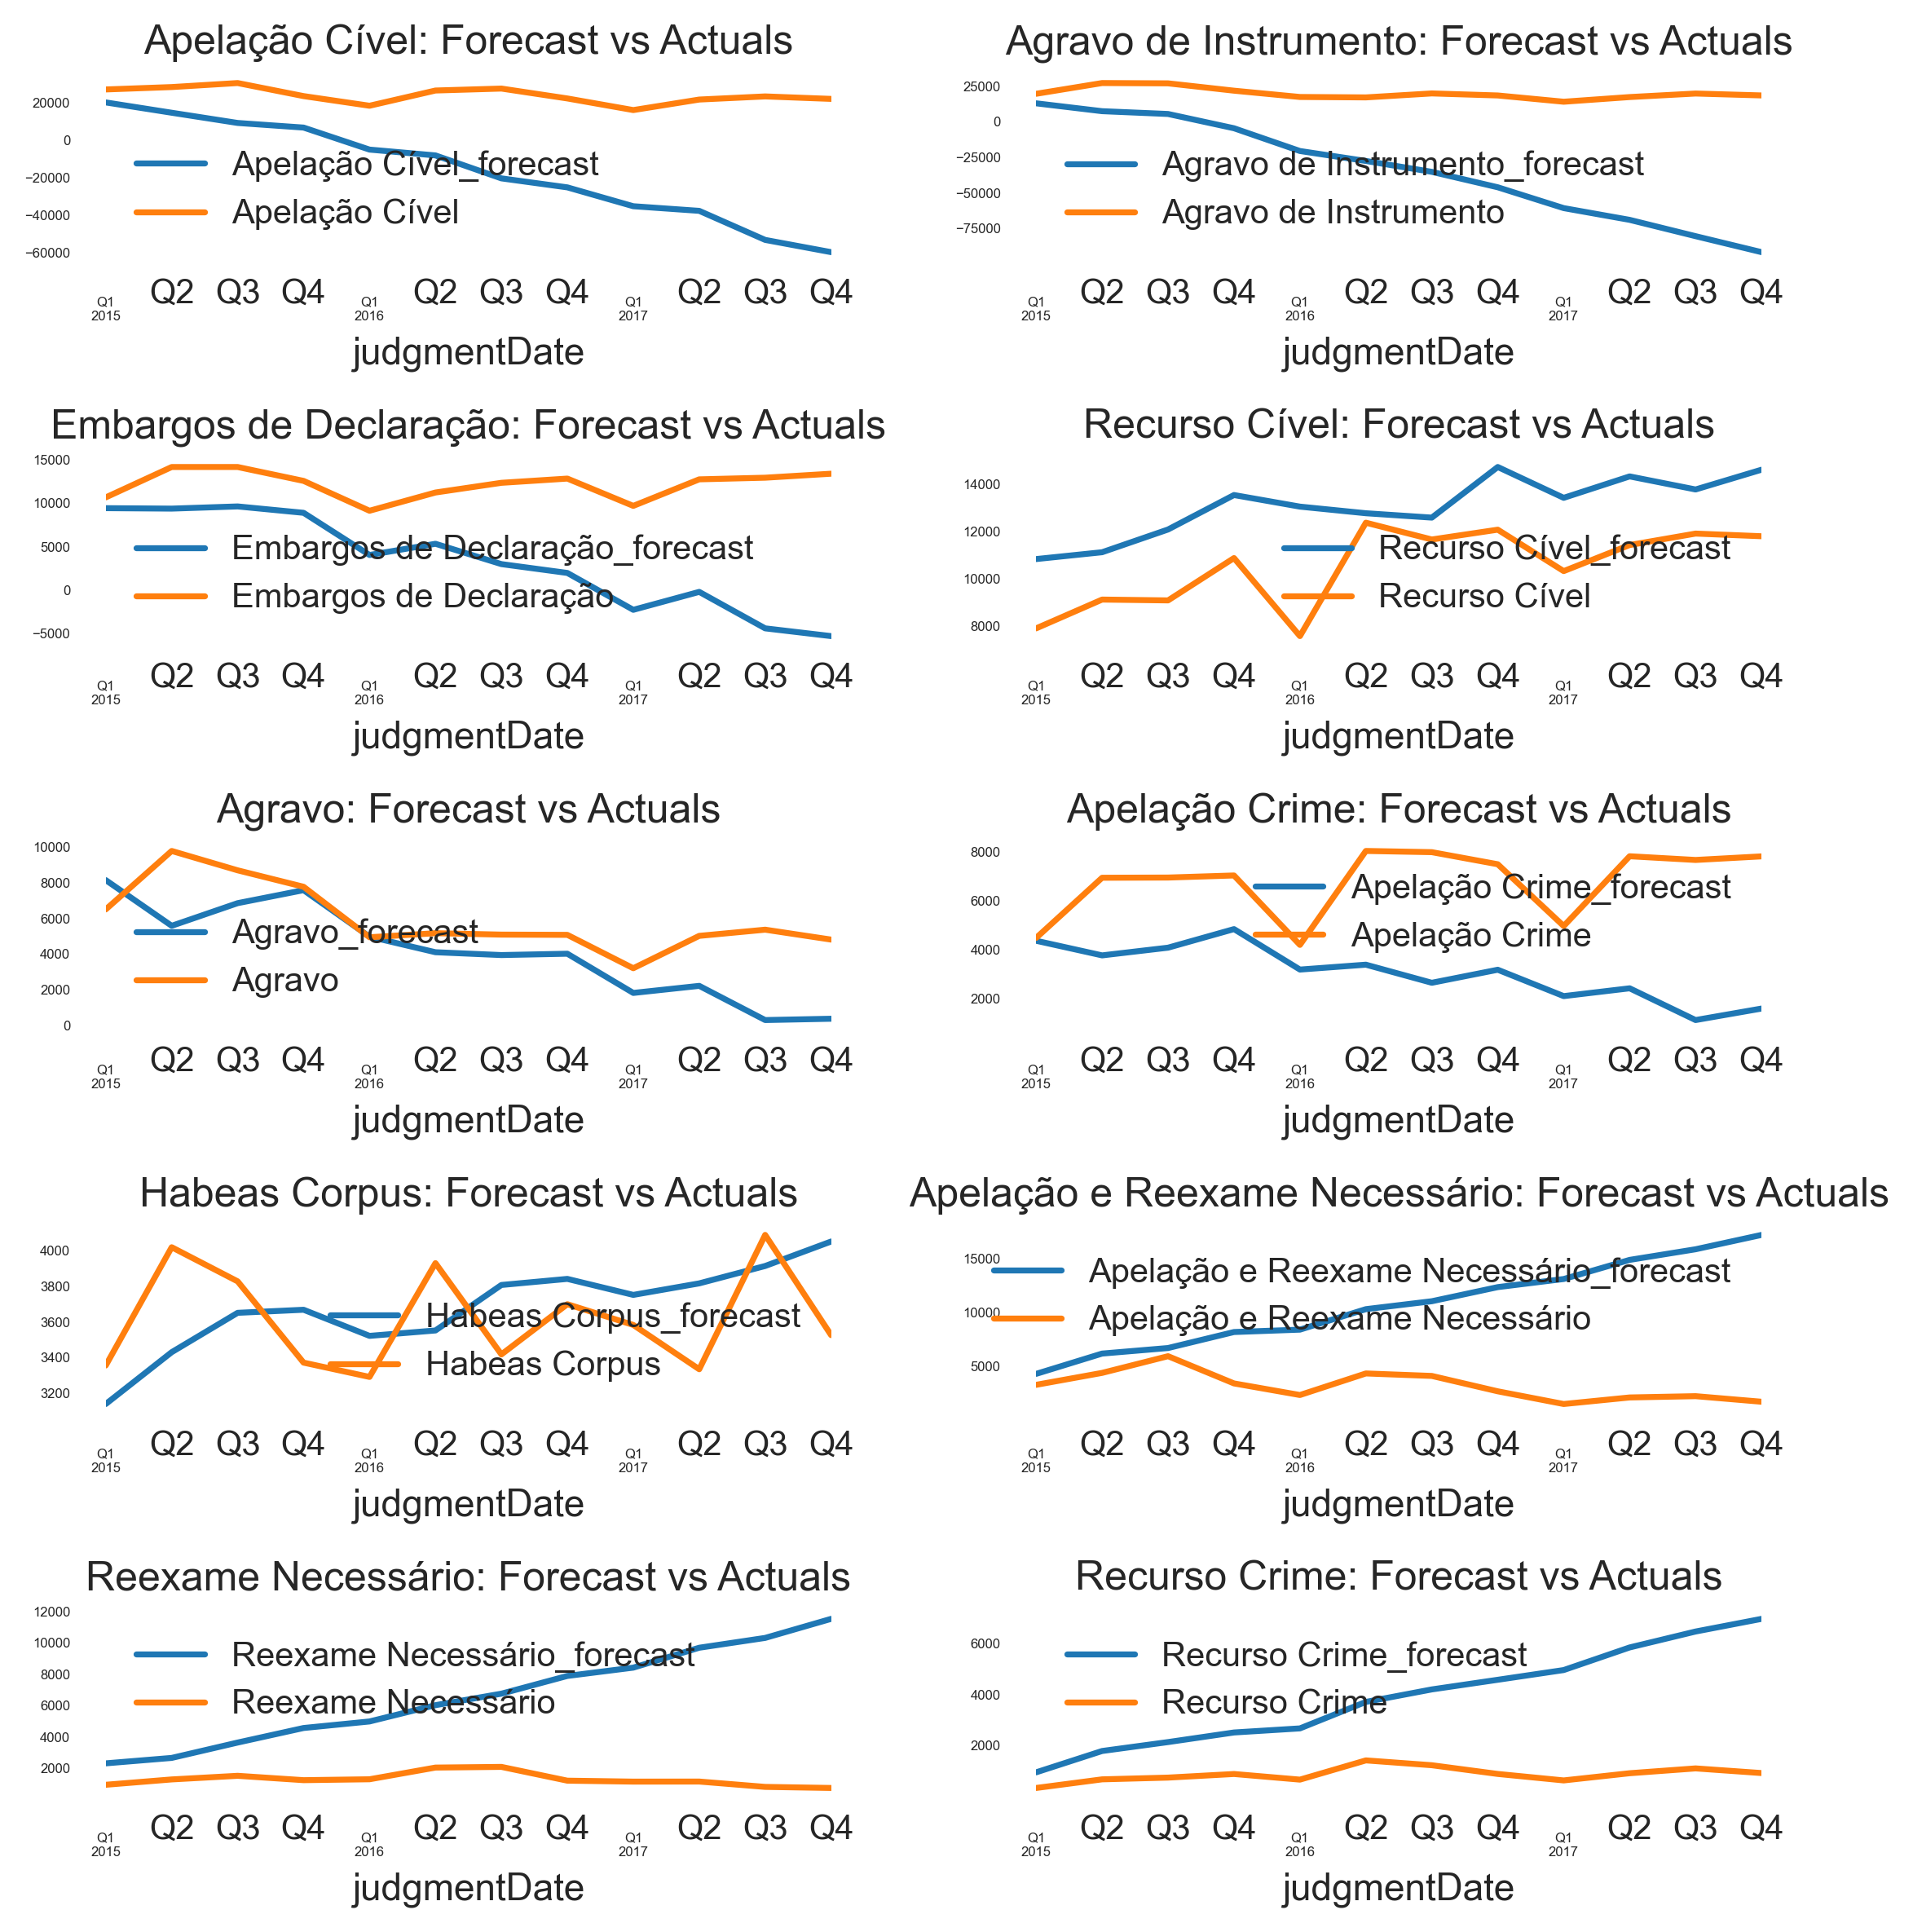

In [936]:
fig, axes = plt.subplots(nrows=int(len(dfVAR2.columns)/2), ncols=2, dpi=300, figsize=(8,8))
for i, (col,ax) in enumerate(zip(dfVAR2.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dfVAR2_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    #ax.xaxis.set_ticks_position('none')
    #ax.yaxis.set_ticks_position('none')
    #ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=4)

plt.tight_layout();

In [927]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

for i in colunas:
    print(i)
    itemI = i.replace('_forecast','')
    print(f'Forecast Accuracy of: {itemI}')
    accuracy_prod = forecast_accuracy(df_results[i].values, dfVAR2_test[itemI])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))
    print('\n')

Apelação Cível_forecast
Forecast Accuracy of: Apelação Cível
mape   :  1.7845
me     :  -40226.4087
mae    :  40226.4087
mpe    :  -1.7845
rmse   :  46676.2341
corr   :  0.5388
minmax :  1.7845


Agravo de Instrumento_forecast
Forecast Accuracy of: Agravo de Instrumento
mape   :  2.9543
me     :  -54057.9874
mae    :  54057.9874
mpe    :  -2.9543
rmse   :  62936.8395
corr   :  0.6026
minmax :  2.9543


Embargos de Declaração_forecast
Forecast Accuracy of: Embargos de Declaração
mape   :  0.7285
me     :  -8871.0243
mae    :  8871.0243
mpe    :  -0.7285
rmse   :  10356.2374
corr   :  0.0817
minmax :  0.7285


Recurso Cível_forecast
Forecast Accuracy of: Recurso Cível
mape   :  0.2644
me     :  2560.8293
mae    :  2560.8293
mpe    :  0.2644
rmse   :  2830.6099
corr   :  0.6695
minmax :  0.197


Agravo_forecast
Forecast Accuracy of: Agravo
mape   :  0.3687
me     :  -1795.4871
mae    :  2074.8598
mpe    :  -0.3255
rmse   :  2624.6905
corr   :  0.6538
minmax :  0.3644


Apelação Crime_fore

# PROPHET

In [400]:
# Python
import pandas as pd
from fbprophet import Prophet


dfProphet = dfMonth[['total']].copy()

#dfProphet = dfProphet.diff()

print(adf_teste(dfProphet.diff()))


dfProphetTrain = dfProphet[:'2016-01-01']
dfProphetTrain = dfProphetTrain.reset_index()
dfProphetTrain.columns = ['ds','y']

dfProphetTest = dfProphet['2016-01-01':]
dfProphetTest = dfProphetTest.reset_index()
dfProphetTest.columns = ['ds','y']

dfProphet = dfProphet.reset_index()
dfProphet.columns = ['ds','y']

#display(dfMonth.tail())
#display(dfProphet.tail())
#display(dfProphetTrain.tail())
#display(dfProphetTest.tail())

(0.005359290063266703, '', -3.6217099251587053, 15, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 3939.1954624144064, 'Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary')


In [500]:
#dfProphet['cap']
dfFeriados = df_count_day_type.reset_index()
dfFeriados = dfFeriados[['judgmentDate','Feriado']]
feriados = pd.Series(dfFeriados[dfFeriados['Feriado']==True]['judgmentDate'])
np.array(feriados)

feriadosGauchos = pd.DataFrame({
  'holiday': 'feriadosGauchos',
  'ds': pd.to_datetime(feriados),
  'lower_window': 0,
  'upper_window': 1,
})


def is_year_season(ds):
    date = pd.to_datetime(ds)
    return (date.month == 6  or date.month ==6)

dfProphet['on_season'] = dfProphet['ds'].apply(is_year_season)
dfProphet['off_season'] = ~dfProphet['ds'].apply(is_year_season)


dfProphetTrain['on_season'] = dfProphetTrain['ds'].apply(is_year_season)
dfProphetTrain['off_season'] = ~dfProphetTrain['ds'].apply(is_year_season)

In [501]:
m = Prophet(yearly_seasonality=12,changepoint_prior_scale=0.1,holidays=feriadosGauchos)
#m.add_seasonality(name='yearly', period=1, fourier_order=12)


m.add_country_holidays(country_name='BR')

m.fit(dfProphetTrain)
print(m.train_holiday_names)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0               feriadosGauchos
1                New Year's Day
2                    Tiradentes
3                  Worker's Day
4              Independence Day
5    Our Lady of the Apparition
6                All Souls' Day
7     Republic Proclamation Day
8                     Christmas
dtype: object


In [502]:
future = m.make_future_dataframe(periods=23,freq='MS')
future.tail()

ds
211 2017-08-01
212 2017-09-01
213 2017-10-01
214 2017-11-01
215 2017-12-01

In [503]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
211 2017-08-01  39064.535911  34199.940953  44241.949421
212 2017-09-01  35158.934063  29917.055481  40377.045889
213 2017-10-01  36928.562441  31884.450473  42004.477992
214 2017-11-01  35854.208195  30676.935078  40709.479140
215 2017-12-01  33441.830992  27872.535131  38146.945708

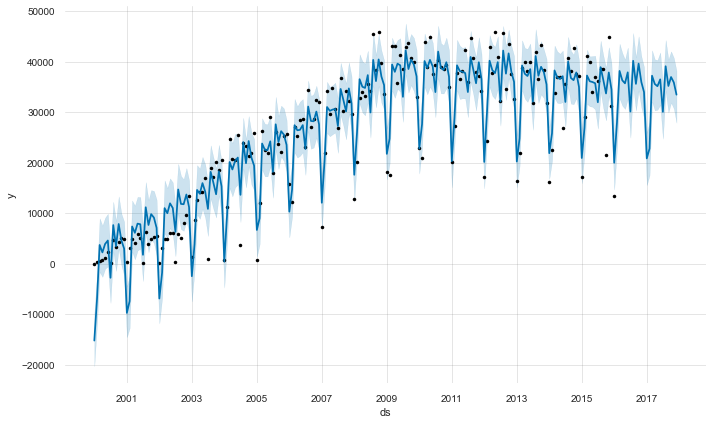

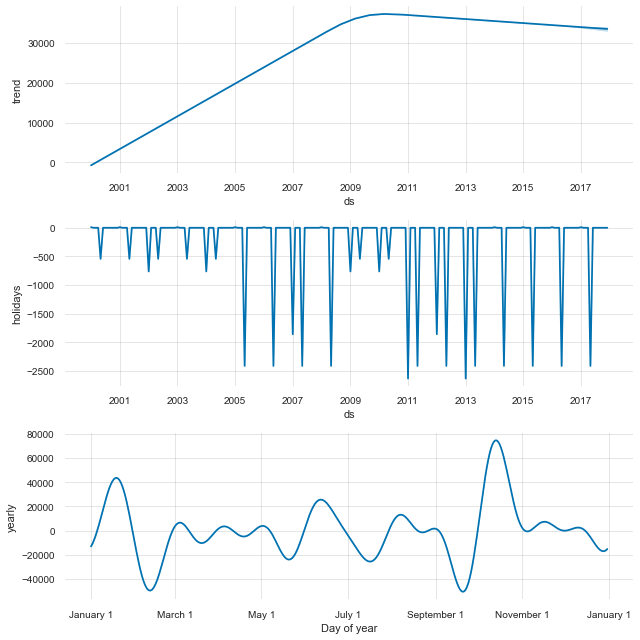

In [504]:
fig1 = m.plot(forecast[:])
fig2 = m.plot_components(forecast[:])


In [505]:
# Python
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
#fig = plot_plotly(dfYear['total'])
py.iplot(fig)

In [506]:
display(dfYear[['total']].tail())
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

dfFaceForecast = forecast

total
judgmentDate        
2013-12-31    418374
2014-12-31    404545
2015-12-31    408733
2016-12-31    403248
2017-12-31    392858

ds          yhat    yhat_lower    yhat_upper
211 2017-08-01  39064.535911  34199.940953  44241.949421
212 2017-09-01  35158.934063  29917.055481  40377.045889
213 2017-10-01  36928.562441  31884.450473  42004.477992
214 2017-11-01  35854.208195  30676.935078  40709.479140
215 2017-12-01  33441.830992  27872.535131  38146.945708

In [507]:
dfFaceForecast.index = pd.to_datetime(dfFaceForecast['ds'])

dfProphetTrain.index = pd.to_datetime(dfProphetTrain['ds'])

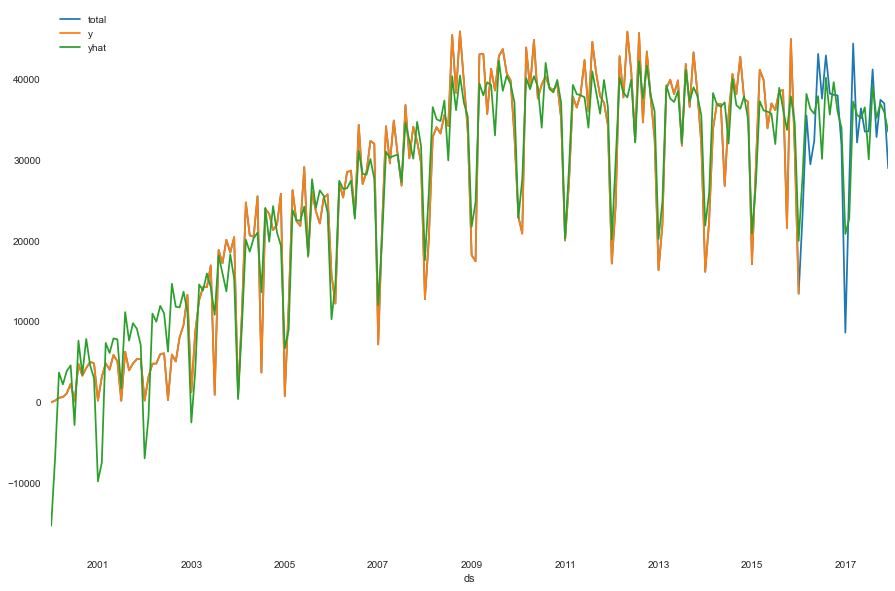

In [508]:
dfMonth['total'].plot(legend=True)
dfProphetTrain['y'].plot(figsize=(15,10),legend=True)
forecast['yhat'].plot(legend=True)

#forecast['yhat_lower'].plot()
#forecast['yhat_upper'].plot()



In [509]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=dfMonth.reset_index()['judgmentDate'], y=dfMonth['total'],mode='lines',name='Real'))
fig.add_trace(go.Scatter(x=dfProphetTrain['ds'], y=dfProphetTrain['y'],mode='lines',name='Treino Prophet'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'],mode='lines',name='Forecast Prophet'))
fig.show()

In [521]:
#4058.41476496912

print(rmse(dfProphet['y'],forecast['yhat']))

4058.41476496912


In [522]:
forecast.shape

(216, 46)

In [523]:
# UDEMY

In [645]:
import pandas as pd
from fbprophet import Prophet


dfProphetU = dfMonth[['Agravo']].copy()



#dfProphet = dfProphet.diff()
#print(adf_teste(dfProphetU.diff()))


dfProphetTrainU = dfProphetU[:-12]
dfProphetTrainU = dfProphetTrainU.reset_index()
dfProphetTrainU.columns = ['ds','y']

dfProphetTestU = dfProphetU[-12:]
dfProphetTestU = dfProphetTestU.reset_index()
dfProphetTestU.columns = ['ds','y']

dfProphetU = dfProphetU.reset_index()
dfProphetU.columns = ['ds','y']


#dfProphetTrainU['on_season'] = dfProphetTrainU['ds'].apply(is_year_season)
#dfProphetTrainU['off_season'] = ~dfProphetTrainU['ds'].apply(is_year_season)

display(dfMonth.head())
display(dfProphetU.tail())
display(dfProphetTrainU.tail())
display(dfProphetTestU.tail())

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2000-01-01       10               0                     10   
2000-02-01      222             151                     35   
2000-03-01      573             277                     93   
2000-04-01      647             343                    145   
2000-05-01     1096             595                    318   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2000-01-01                         0              0       0               0   
2000-02-01                         2              0       4               1   
2000-03-01                        30              0      17               5   
2000-04-01                        19              0      18               3   
2000-05-01                        78              0      11               7   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2000-01-01                0                              0   
2000-02-01                0                             25   
2000-03-01                0                            118   
2000-04-01                2                             89   
2000-05-01                3                             53   

              Reexame Necessário  ...  Medida Cautelar  Desaforamento  \
judgmentDate                      ...                                   
2000-01-01                     0  ...                0              0   
2000-02-01                     1  ...                0              0   
2000-03-01                    21  ...                0              0   
2000-04-01                    14  ...                0              0   
2000-05-01                    16  ...                1              0   

              Crimes contra a honra  Incidente de Inconstitucionalidade  \
judgmentDate                                                              
2000-01-01                        0                                   0   
2000-02-01                        0                                   0   
2000-03-01                        0                                   0   
2000-04-01                        0                                   0   
2000-05-01                        0                                   0   

              Impugnação à Assistência Judiciária  \
judgmentDate                                        
2000-01-01                                      0   
2000-02-01                                      0   
2000-03-01                                      0   
2000-04-01                                      0   
2000-05-01                                      0   

              Impugnação ao Valor da Causa  Inquérito Policial  weekDay  \
judgmentDate                                                              
2000-01-01                               0                   0       84   
2000-02-01                               0                   0       85   
2000-03-01                               0                   0       93   
2000-04-01                               0                   0       95   
2000-05-01                               1                   0       87   

              weekType  Feriado  
judgmentDate                     
2000-01-01          21       29  
2000-02-01          21       29  
2000-03-01          23       31  
2000-04-01          20       29  
2000-05-01          23       30  

[5 rows x 50 columns]

ds     y
211 2017-08-01  1977
212 2017-09-01  1700
213 2017-10-01  1382
214 2017-11-01  1905
215 2017-12-01  1527

ds     y
199 2016-08-01  1982
200 2016-09-01  1786
201 2016-10-01  1907
202 2016-11-01  1739
203 2016-12-01  1434

ds     y
7  2017-08-01  1977
8  2017-09-01  1700
9  2017-10-01  1382
10 2017-11-01  1905
11 2017-12-01  1527

In [668]:
m = Prophet(yearly_seasonality=True,seasonality_mode='multiplicative')
m.fit(dfProphetTrainU)
print(m.train_holiday_names)
futureU = m.make_future_dataframe(periods=12,freq='MS')
print(len(dfProphetU),len(futureU))
forecastU =m.predict(futureU)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


None
216 216


In [669]:
forecastU.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
211 2017-08-01  2028.684762  1940.105434  3175.674926  2016.595123   
212 2017-09-01  2011.518833  1560.299016  2814.033770  1996.710515   
213 2017-10-01  1994.906643  1625.052120  2790.190810  1977.251157   
214 2017-11-01  1977.740714  1683.682093  2897.415902  1956.437506   
215 2017-12-01  1961.128525  1215.074513  2468.374632  1934.722145   

     trend_upper  multiplicative_terms  multiplicative_terms_lower  \
211  2043.509089              0.267970                    0.267970   
212  2029.720895              0.082854                    0.082854   
213  2016.813925              0.104846                    0.104846   
214  2003.933808              0.154696                    0.154696   
215  1991.256965             -0.045374                   -0.045374   

     multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
211                    0.267970  0.267970      0.267970      0.267970   
212                    0.082854  0.082854      0.082854      0.082854   
213                    0.104846  0.104846      0.104846      0.104846   
214                    0.154696  0.154696      0.154696      0.154696   
215                   -0.045374 -0.045374     -0.045374     -0.045374   

     additive_terms  additive_terms_lower  additive_terms_upper         yhat  
211             0.0                   0.0                   0.0  2572.311239  
212             0.0                   0.0                   0.0  2178.180930  
213             0.0                   0.0                   0.0  2204.064441  
214             0.0                   0.0                   0.0  2283.689338  
215             0.0                   0.0                   0.0  1872.145192

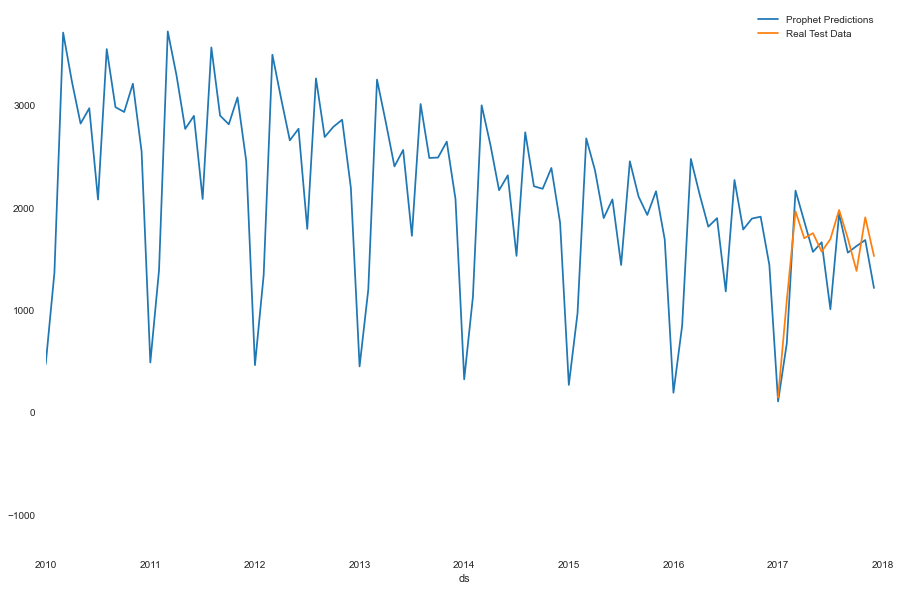

In [681]:
ax = forecastU.plot(x='ds',y='yhat_lower',label='Prophet Predictions',legend=True,figsize=(15,10))
dfProphetTestU.plot(x='ds',y='y',label='Real Test Data',legend=True,ax=ax,xlim=('2010-01-01','2018-01-01'))

In [671]:
from statsmodels.tools.eval_measures import rmse
predictionsProphet = forecastU.iloc[-12:]['yhat']

In [683]:
#651.8792488709176 y    1534.416667   add
#565.9583305657293 y    1534.416667   mul

print(rmse(predictionsProphet,dfProphetTestU['y']),dfProphetTestU.mean())

565.9583305657293 y    1534.416667
dtype: float64


In [685]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=dfMonth.reset_index()['judgmentDate'], y=dfMonth['Agravo'],mode='lines',name='Real'))
fig.add_trace(go.Scatter(x=dfProphetTrainU['ds'], y=dfProphetTrainU['y'],mode='lines',name='Treino Prophet'))
fig.add_trace(go.Scatter(x=forecastU['ds'], y=forecastU['yhat'],mode='lines',name='Forecast Prophet'))
fig.show()

In [673]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [674]:
initial = 5*365
initial = str(initial)+' days'

period = 5*365
period = str(period)+' days'

horizon = 365
horizon = str(horizon) + ' days'


In [675]:
initial,period,horizon

('1825 days', '1825 days', '365 days')

In [676]:
dfProphetCv = cross_validation(m, initial=initial, period=period,horizon=horizon)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2005-12-04 00:00:00 and 2015-12-02 00:00:00


In [682]:
performance_metrics(dfProphetCv).head()

horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  576449.493198  759.242710  650.190345  0.637864  0.591702  0.666667
1 59 days   96667.516310  310.914001  283.282457  0.347456  0.333237  1.000000
2 60 days   53039.050622  230.302086  203.217241  0.258449  0.117430  1.000000
3 61 days   45428.213012  213.138952  191.921650  0.136110  0.117430  1.000000
4 87 days   86652.676890  294.368267  279.627622  0.158523  0.184672  0.666667

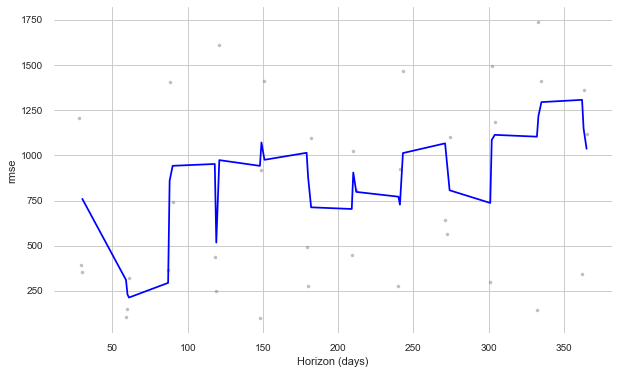

In [678]:
plot_cross_validation_metric(dfProphetCv,metric='rmse');

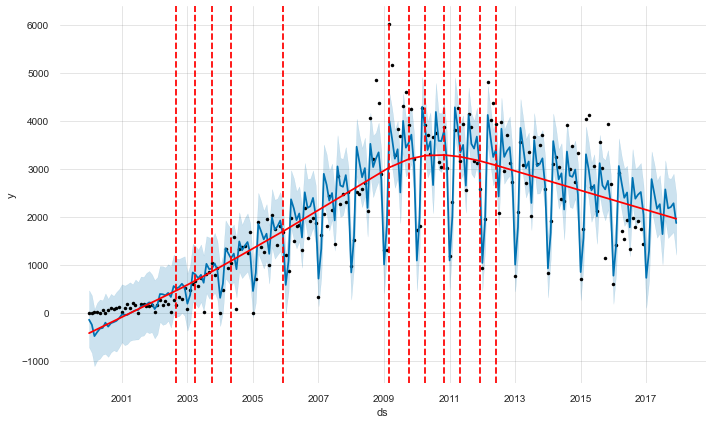

In [679]:
forecastU
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecastU)
a = add_changepoints_to_plot(fig.gca(),m,forecastU)

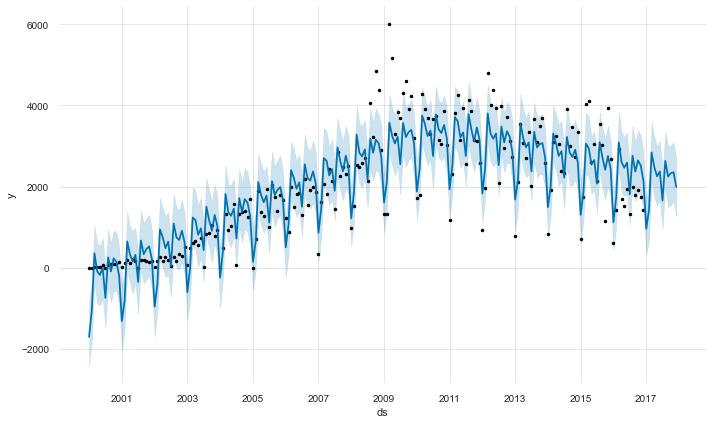

In [665]:
figg = m.plot(forecastU)

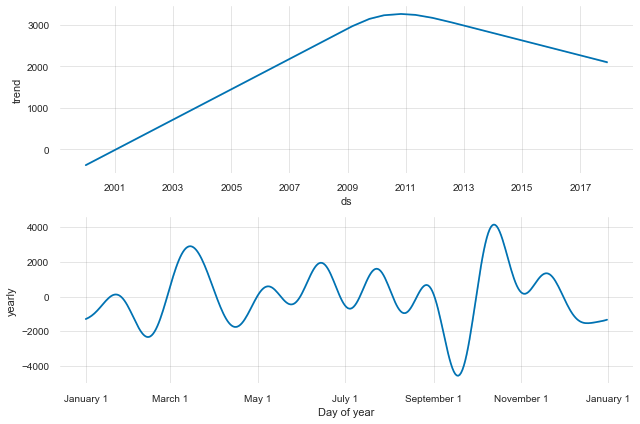

In [666]:
fig = m.plot_components(forecastU)

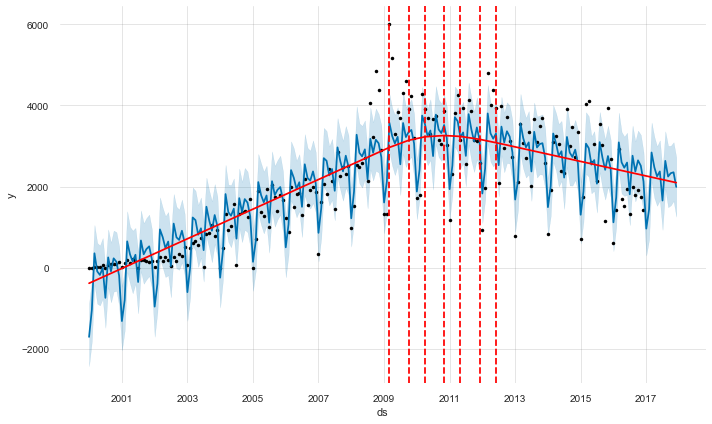

In [667]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecastU)
a = add_changepoints_to_plot(fig.gca(),m,forecastU)

In [643]:
m = Prophet(yearly_seasonality=True,seasonality_mode='multiplicative')
m.fit(dfProphetTrainU)
print(m.train_holiday_names)
futureU = m.make_future_dataframe(periods=12,freq='MS')
print(len(dfProphetU),len(futureU))
forecastU =m.predict(futureU)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


None
216 216


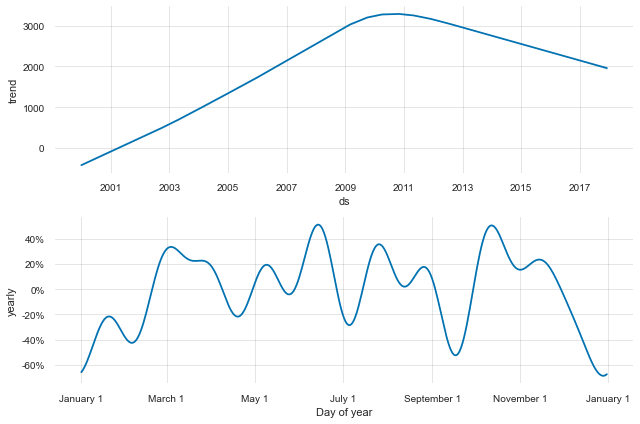

In [644]:
fig = m.plot_components(forecastU)

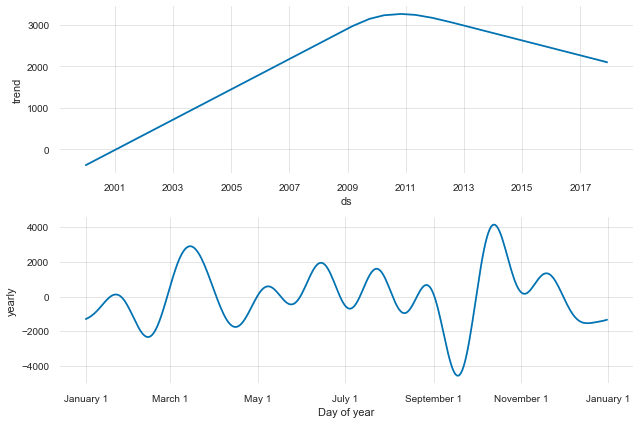

In [641]:
fig = m.plot_components(forecastU)

In [598]:
print(len(forecastU))
print(forecastU.columns)

216
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [599]:
forecastU[['ds', 'trend', 'yhat_lower', 'yhat_upper']]

ds        trend   yhat_lower   yhat_upper
0   2000-01-01  -383.229966 -2448.130541  -966.668533
1   2000-02-01  -352.249635 -1808.567085  -288.607424
2   2000-03-01  -323.268036  -346.125041  1107.166274
3   2000-04-01  -292.287706  -785.560729   646.316793
4   2000-05-01  -262.306742  -903.971396   564.131918
..         ...          ...          ...          ...
211 2017-08-01  2157.585590  1943.104446  3433.539085
212 2017-09-01  2142.364131  1525.460987  2986.796038
213 2017-10-01  2127.633686  1591.943974  3066.022578
214 2017-11-01  2112.412227  1596.900579  3069.710753
215 2017-12-01  2097.681782  1235.900143  2673.607087

[216 rows x 4 columns]

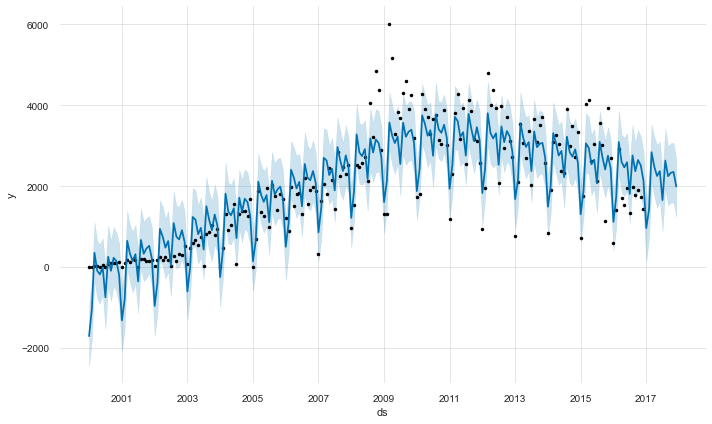

In [600]:
import matplotlib.pyplot as plt
%matplotlib inline
m.plot(forecastU);
#plt.xlim('2015-01-01','2018-01-01')

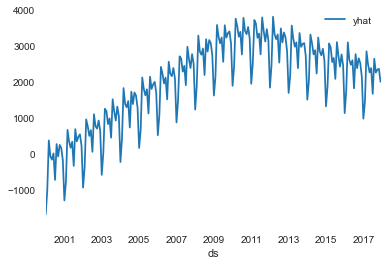

In [601]:
forecastU.plot(x='ds',y='yhat')